In [68]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.express as px

sns.set()

In [2]:
def process(x):
    df = x.copy()
    df.date = pd.to_datetime(df.date, unit='s')
    df.views = df.views.replace(-1, np.NaN)
    df.text = df.text.astype('string')
    df.views = df.views.astype('Int64')
    return df

In [3]:
data = pd.read_parquet('data/news.parq').pipe(process)
data.head()

,date,text,likes,reposts,views,marked_as_ads,group
0,2021-03-23 20:27:00,"В Кремле сообщили, что Владимир Путин привился...",14,6,1363,False,bbc
1,2021-03-23 20:00:03,Некоторые вирусы хотят быть единоличными захва...,16,12,1806,False,bbc
2,2021-03-23 19:24:00,Принц Гарри не раз признавался в собственных п...,13,7,2383,False,bbc
3,2021-03-23 19:00:06,"Ученые считают, что чашка эспрессо за полчаса ...",18,15,2528,False,bbc
4,2021-03-23 18:24:00,Под Киевом школьник оказался на льдине. Глубин...,54,22,3941,False,bbc


In [4]:
mem_usg = data.memory_usage(deep=True) / 1024 ** 2
mem_usg

Index            0.000122
date             1.734085
text             1.734085
likes            1.734085
reposts          1.734085
views            1.950846
marked_as_ads    0.216761
group            0.217223
dtype: float64

Text(0, 0.5, 'posts')

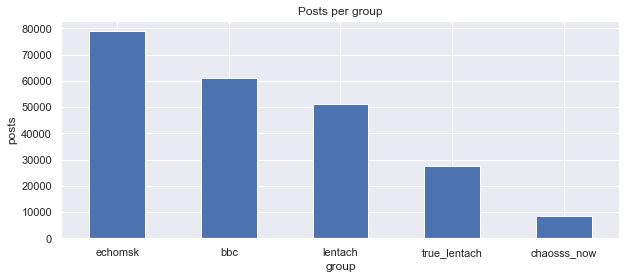

In [5]:
data.group.value_counts().plot.bar(figsize=(10, 4))
plt.xticks(rotation=0)
plt.title('Posts per group')
plt.xlabel('group')
plt.ylabel('posts')

In [6]:
# Likes, reposts, views statistics
(
    data.describe(percentiles=np.arange(0, 1, .1))
        .round()
        .astype('int64'))

,likes,reposts,views
count,227290,227290,167252
mean,1026,46,71454
std,2111,210,138079
min,0,0,179
0%,0,0,179
10%,10,0,3936
20%,17,1,5176
30%,26,2,6195
40%,37,4,7075
50%,55,5,8292


Text(0.5, 1.0, 'Likes distribution')

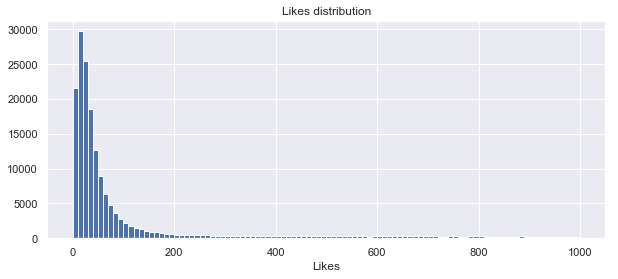

In [7]:
data.likes.hist(bins=100, range=(0, 1000), figsize=(10, 4))
plt.xlabel('Likes')
plt.title('Likes distribution')

Text(0.5, 1.0, 'Reposts distribution')

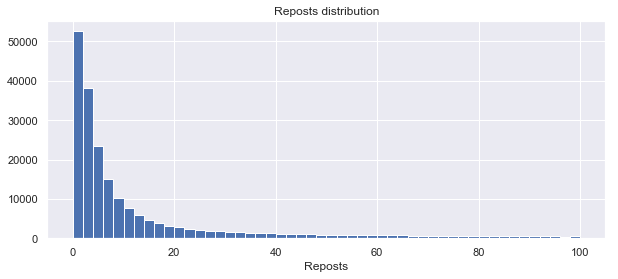

In [8]:
data.reposts.hist(bins=50, range=(0, 100), figsize=(10, 4))
plt.xlabel('Reposts')
plt.title('Reposts distribution')

Text(0.5, 1.0, 'Views distribution')

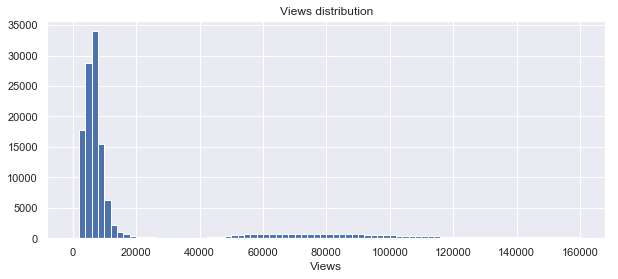

In [15]:
(
    data.views
        .dropna()
        .astype('int64')
        .hist(bins=80, range=(0, 160000), figsize=(10, 4)))
plt.xlabel('Views')
plt.title('Views distribution')

In [18]:
data.marked_as_ads.value_counts(normalize=True)

False    0.996713
True     0.003287
Name: marked_as_ads, dtype: float64

In [76]:
likes_dynamics = (
    data.groupby(pd.Grouper(key='date', freq='w'))
        .likes
        .mean()['2014-06-01': ]
)

px.line(
    x=likes_dynamics.index, y=likes_dynamics.values,
    title='Mean likes dynamics', 
    labels={"x": "Date", "y": "Mean like",})

In [78]:
reposts_dynamics = (
    data.groupby(pd.Grouper(key='date', freq='w'))
        .reposts
        .mean()['2014-06-01': ])

px.line(
    x=reposts_dynamics.index, y=reposts_dynamics.values,
    title='Mean repost number dynamics', 
    labels={"x": "Date", "y": "Mean repost number",})

In [79]:
views_dynamics = (
    data.groupby(pd.Grouper(key='date', freq='w'))
        .views
        .mean()['2017-01-01': ])

px.line(
    x=views_dynamics.index, y=views_dynamics.values,
    title='Mean views dynamics', 
    labels={"x": "Date", "y": "Mean views",})

In [105]:
likes_dynamics_per_group = data.pivot_table(
    index=pd.Grouper(key='date', freq='w'), columns='group',
    values='likes', aggfunc='mean'
)['2014-06-01': ]
trace = [
    go.Scatter(
        x=likes_dynamics_per_group.index, 
        y=likes_dynamics_per_group[col], name=col) for col in likes_dynamics_per_group.columns
]

fig = go.Figure(
    trace, 
    layout={
        'title': 'Mean like dynamics per group', 'xaxis_title': 'Date',
        'yaxis_title': 'Mean likes'
    }
)
fig

In [106]:
reposts_dynamics_per_group = data.pivot_table(
    index=pd.Grouper(key='date', freq='w'), columns='group',
    values='reposts', aggfunc='mean'
)['2014-06-01': ]

trace = [
    go.Scatter(
        x=reposts_dynamics_per_group.index, 
        y=reposts_dynamics_per_group[col], name=col)
    for col in reposts_dynamics_per_group.columns
]

fig = go.Figure(
    trace, 
    layout={
        'title': 'Mean reposts dynamics per group',
        'xaxis_title': 'Date',
        'yaxis_title': 'Mean reposts'
    }
)
fig

In [107]:
views_dynamics_per_group = data.pivot_table(
    index=pd.Grouper(key='date', freq='w'), columns='group',
    values='reposts', aggfunc='mean'
)['2017-01-01': ]

trace = [
    go.Scatter(
        x=reposts_dynamics_per_group.index, 
        y=reposts_dynamics_per_group[col], name=col)
    for col in reposts_dynamics_per_group.columns
]

fig = go.Figure(
    trace, 
    layout={
        'title': 'Mean views',
        'xaxis_title': 'Date',
        'yaxis_title': 'Mean views'
    }
)
fig